In [13]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.svm import SVR

In [33]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']
#XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P', 'logP']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X


print(type(X))

numData = len(data.index)
numTrain = int(numData * 0.7)
numTest = int(numData * .15) 
# print(numTest, numTrain)
train_Frame, valid_Frame, test_Frame, train_valid_Frame = data.iloc[:numTrain, :], data.iloc[numTrain:-numTest, :], data.iloc[-numTest:, :], data.iloc[:-numTest:, :]





<class 'numpy.ndarray'>


TotalT
Lowest Error In Validation _MSE_  9.163490713960037
Temp
Lowest Error In Validation _MSE_  11.601712532257933
LSR
Lowest Error In Validation _MSE_  8.985737943335169
CA
Lowest Error In Validation _MSE_  8.6732504441523
Size
Lowest Error In Validation _MSE_  8.50399718958668
Moisture
Lowest Error In Validation _MSE_  8.549195687002662
IsoT
Lowest Error In Validation _MSE_  9.333908722662796
HeatT
Lowest Error In Validation _MSE_  9.07950981202183
Ramp
Lowest Error In Validation _MSE_  8.354983495511144
F_X
Lowest Error In Validation _MSE_  8.39341406656026


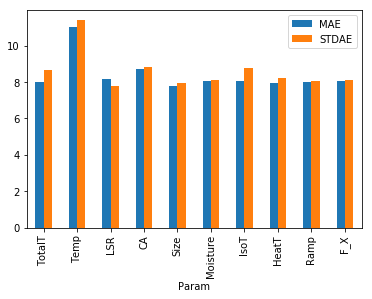

In [34]:
#SVR

resultsFrame = pd.DataFrame(columns=['Param', 'MAE', 'STDAE'])

for i in XLabels:
    print(i)
    remainingX = XLabels.copy()
    remainingX.remove(i)
    
    X = data[remainingX].values
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

    
    kernels =  ['poly', 'rbf', 'linear']
    epsilons = [0.1,5,10, 20]
    Cs = [0.1,1,10, 20]
    gammas = ['scale', 'auto']
    errors = []

    for kern in kernels:
        for ep in epsilons:
            for C_ in Cs:
                for gam in gammas:
                    svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
    #                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                    svrModel.fit(X_train, y_train)
                    y_pred = svrModel.predict(X_valid)
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    errors.append(error)


    index_of_lowest_error = np.argmin(errors)
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
    best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
    best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
    best_gamma = gammas[int(index_of_lowest_error % len(gammas))]

#     print("Best kernel is: ", best_kernel)
#     print("Best Epsilon is: ", best_ep)
#     print("Best C is: ", best_C)
#     print("Best Gamma is: ", best_gamma)



    best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
    # best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
    best_model.fit(X_train_valid, y_train_valid)
    y_pred = best_model.predict(X_test)

    
    error = metrics.mean_absolute_error(y_test, y_pred)
    diff = np.absolute(y_test - y_pred)
    stdev = np.std(diff)
    
    row = [[i, error, stdev]]
    tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
    resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)

resultsFrame.to_csv("paraemters.csv")
resultsFrame.plot(kind='bar', stacked=False, x='Param')
    

In [ ]:
#ANN